In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cosmos98/twitter-and-reddit-sentimental-analysis-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'twitter-and-reddit-sentimental-analysis-dataset' dataset.
Path to dataset files: /kaggle/input/twitter-and-reddit-sentimental-analysis-dataset


In [ ]:
import os

os.listdir(path)

['Twitter_Data.csv', 'Reddit_Data.csv']

In [ ]:
!pip install -U transformers datasets


In [ ]:
import transformers
print(transformers.__version__)

5.0.0


In [ ]:
import pandas as pd
import re
from datasets import Dataset
from datasets import ClassLabel
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers.generation.utils import GenerationMixin
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Loading the dataset
twitter_data = pd.read_csv(f"{path}/Twitter_Data.csv")
reddit_data = pd.read_csv(f"{path}/Reddit_Data.csv")

In [ ]:
twitter_data.shape, reddit_data.shape

((162980, 2), (37249, 2))

In [ ]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [ ]:
reddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [ ]:
# Renaming Columns
twitter_data.rename(columns={"clean_text": "Comment"}, inplace=True)
reddit_data.rename(columns={"clean_comment": "Comment"}, inplace=True)


In [ ]:
reddit_data.head()

,Comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [ ]:
twitter_data = twitter_data.dropna()
reddit_data = reddit_data.dropna()

In [ ]:
# Converting dtype of category column in twitter data set into int.
twitter_data["category"] = twitter_data["category"].astype(int)



In [ ]:
# Combaining and shuffling both the dataset
df = pd.concat([twitter_data, reddit_data], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head()


,Comment,category
0,expanding the campaign has entered 2nd phase w...,-1
1,there rat race among congress leaders who can ...,1
2,government has taken measures set chowkidar sp...,0
3,surgical strike happens\nreason for soldiers n...,1
4,narendra modi and powerful\njoke,1


In [ ]:
textt = " ".join(df['Comment'])

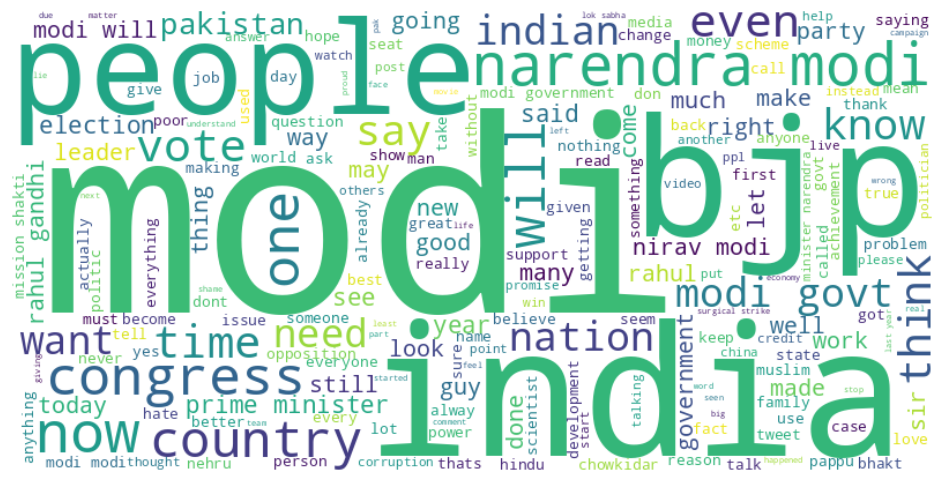

In [ ]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=200
).generate(textt)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [ ]:
# Convert to HuggingFace Dataset
dataset = Dataset.from_pandas(df)
dataset = dataset.rename_column("Comment", "text")
dataset = dataset.rename_column("category", "label")

In [ ]:
print(dataset.column_names)

['text', 'label']


In [ ]:
# Cleaning text
def clean_text(text):
    text = re.sub(r"http\S+", "<URL>", text)
    text = re.sub(r"@\w+", "<USER>", text)
    text = text.lower()
    return text

dataset = dataset.map(lambda x: {"text": clean_text(x["text"])})


Map:   0%|          | 0/200118 [00:00<?, ? examples/s]

In [ ]:
# Remap labels and then convert to ClassLabel
def remap_label(label):
    if label == -1:
        return 0
    elif label == 0:
        return 1
    else:  # label == 1
        return 2

dataset = dataset.map(lambda x: {"label": remap_label(x["label"])})

dataset = dataset.cast_column(
    "label",
    ClassLabel(
        num_classes=3,
        names=["negative", "neutral", "positive"]
    )
)

Map:   0%|          | 0/200118 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/200118 [00:00<?, ? examples/s]

In [ ]:
# Train–test split
dataset = dataset.train_test_split(
    test_size=0.2,
    stratify_by_column="label",
    seed=42
)


In [ ]:
print("Train labels:", np.unique(dataset["train"]["label"]))
print("Test labels:", np.unique(dataset["test"]["label"]))

Train labels: [0 1 2]
Test labels: [0 1 2]


In [ ]:
# DistilBERT tokenizer & model

tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [ ]:
# Tokenizing the dataset
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

dataset = dataset.map(tokenize, batched=True)


Map:   0%|          | 0/160094 [00:00<?, ? examples/s]

Map:   0%|          | 0/40024 [00:00<?, ? examples/s]

In [ ]:
# Setting format for PyTorch
dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)


In [ ]:
training_args = TrainingArguments(
    output_dir="./distilbert_twitter_reddit",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True
)


In [ ]:


def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics
)


In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.092840,0.081201,0.976689,0.976681
2,0.055083,0.066164,0.981836,0.981885
3,0.027646,0.067379,0.985409,0.985415


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=15009, training_loss=0.09040167424632974, metrics={'train_runtime': 5124.2242, 'train_samples_per_second': 93.728, 'train_steps_per_second': 2.929, 'total_flos': 1.5905710441032192e+16, 'train_loss': 0.09040167424632974, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.0661684200167656,
 'eval_accuracy': 0.9818109134519288,
 'eval_f1': 0.98186003848149,
 'eval_runtime': 133.7636,
 'eval_samples_per_second': 299.214,
 'eval_steps_per_second': 9.352,
 'epoch': 3.0}

In [ ]:
import torch

text = "I absolutely love this product!"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

inputs = tokenizer(
    text,
    return_tensors="pt",
    truncation=True,
    padding=True
)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)

pred = outputs.logits.argmax(dim=-1).item()

id2label = {0: "negative", 1: "neutral", 2: "positive"}
print("Prediction:", id2label[pred])



Prediction: positive


In [ ]:
trainer.save_model("sentiment_distilbert")
tokenizer.save_pretrained("sentiment_distilbert")


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('sentiment_distilbert/tokenizer_config.json',
 'sentiment_distilbert/tokenizer.json')